# GLM: Mini-batch ADVI on hierarchical regression model
Unlike Gaussian mixture models, (hierarchical) regression models have independent variables. These variables affect the likelihood function, but are not random variables. When using mini-batch, we should take care of that. 

In [1]:
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt

print('Running on PyMC3 v{}'.format(pm.__version__))

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
Running on PyMC3 v3.9.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
data = pd.read_csv(pm.get_data('radon.csv'))

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())
total_size = len(data)

Here, 'log_radon_t' is a dependent variable, while 'floor_t' and 'county_idx_t' determine independent variable.  

In [4]:
log_radon_t = pm.Minibatch(data.log_radon.values, 100)
floor_t = pm.Minibatch(data.floor.values, 100)
county_idx_t = pm.Minibatch(data.county_code.values, 100)

/dependencies/pymc3/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/dependencies/pymc3/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [5]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sigma=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sigma=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)

Intercept for each county, distributed around group mean mu_a. Above we just set mu and sd to a fixed value while here we plug in a common group distribution for all a and b (which are vectors of length n_counties).

In [6]:
with hierarchical_model:
    
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=n_counties)

Model prediction of radon level `a[county_idx]` translates to `a[0, 0, 0, 1, 1, ...]`, we thus link multiple household measures of a county to its coefficients.

In [7]:
with hierarchical_model:

    radon_est = a[county_idx_t] + b[county_idx_t] * floor_t

Finally, we specify the likelihood:

In [8]:
with hierarchical_model:
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100) 
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sigma=eps, observed=log_radon_t, total_size=len(data))

Random variable 'radon_like', associated with 'log_radon_t', should be given to the function for ADVI to denote that as observations in the likelihood term. 

On the other hand, 'minibatches' should include the three variables above. 

Then, run ADVI with mini-batch. 

In [9]:
with hierarchical_model:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Finished [100%]: Average Loss = 120.48


Check the trace of ELBO and compare the result with MCMC. 

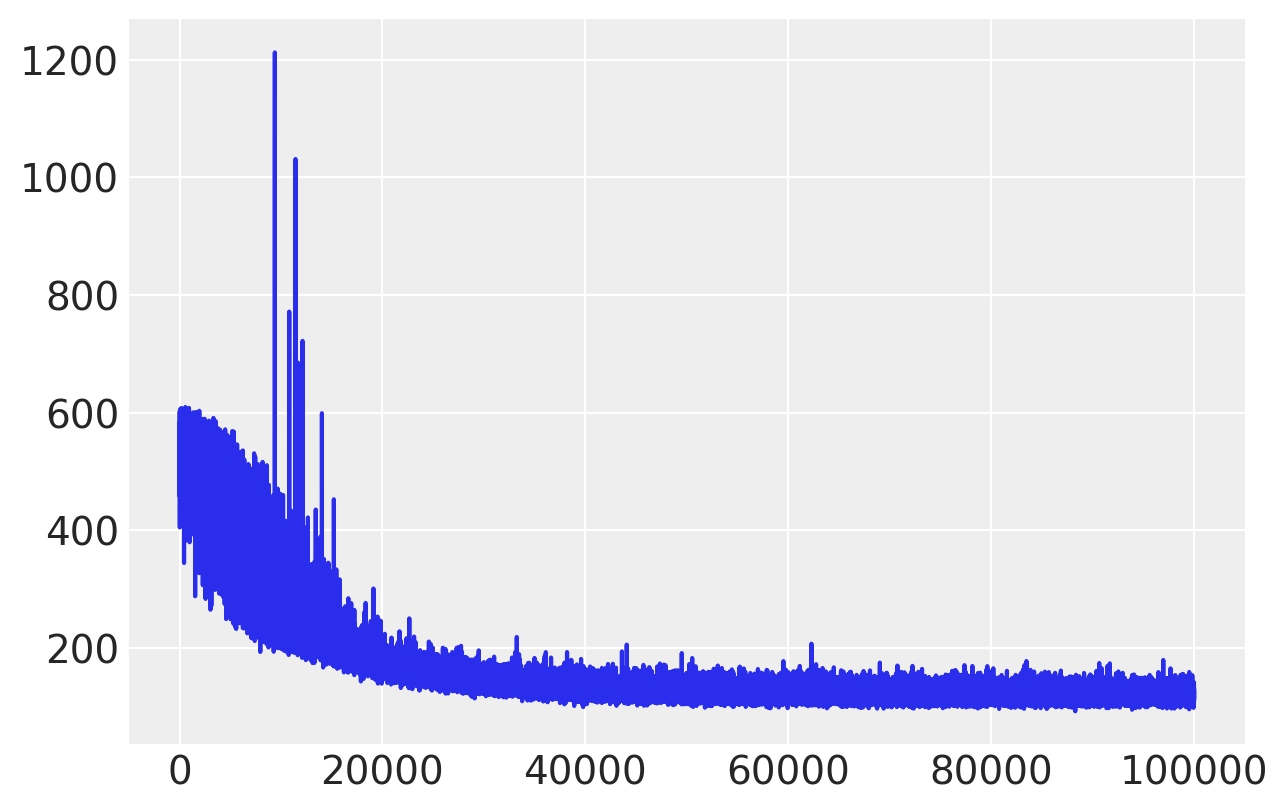

In [10]:
import matplotlib.pyplot as plt

plt.plot(approx.hist);

In [11]:
# Inference button (TM)!
with pm.Model():

    mu_a = pm.Normal('mu_alpha', mu=0., sigma=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sigma=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal(
        'radon_like', mu=radon_est, sigma=eps, observed=data.log_radon.values)
    
    # essentially, this is what init='advi' does
    step = pm.NUTS(scaling=approx.cov.eval(), is_cov=True)
    hierarchical_trace = pm.sample(2000, step, start=approx.sample()[0], progressbar=True)

/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


In [12]:
means = approx.bij.rmap(approx.mean.eval())
sds = approx.bij.rmap(approx.std.eval())

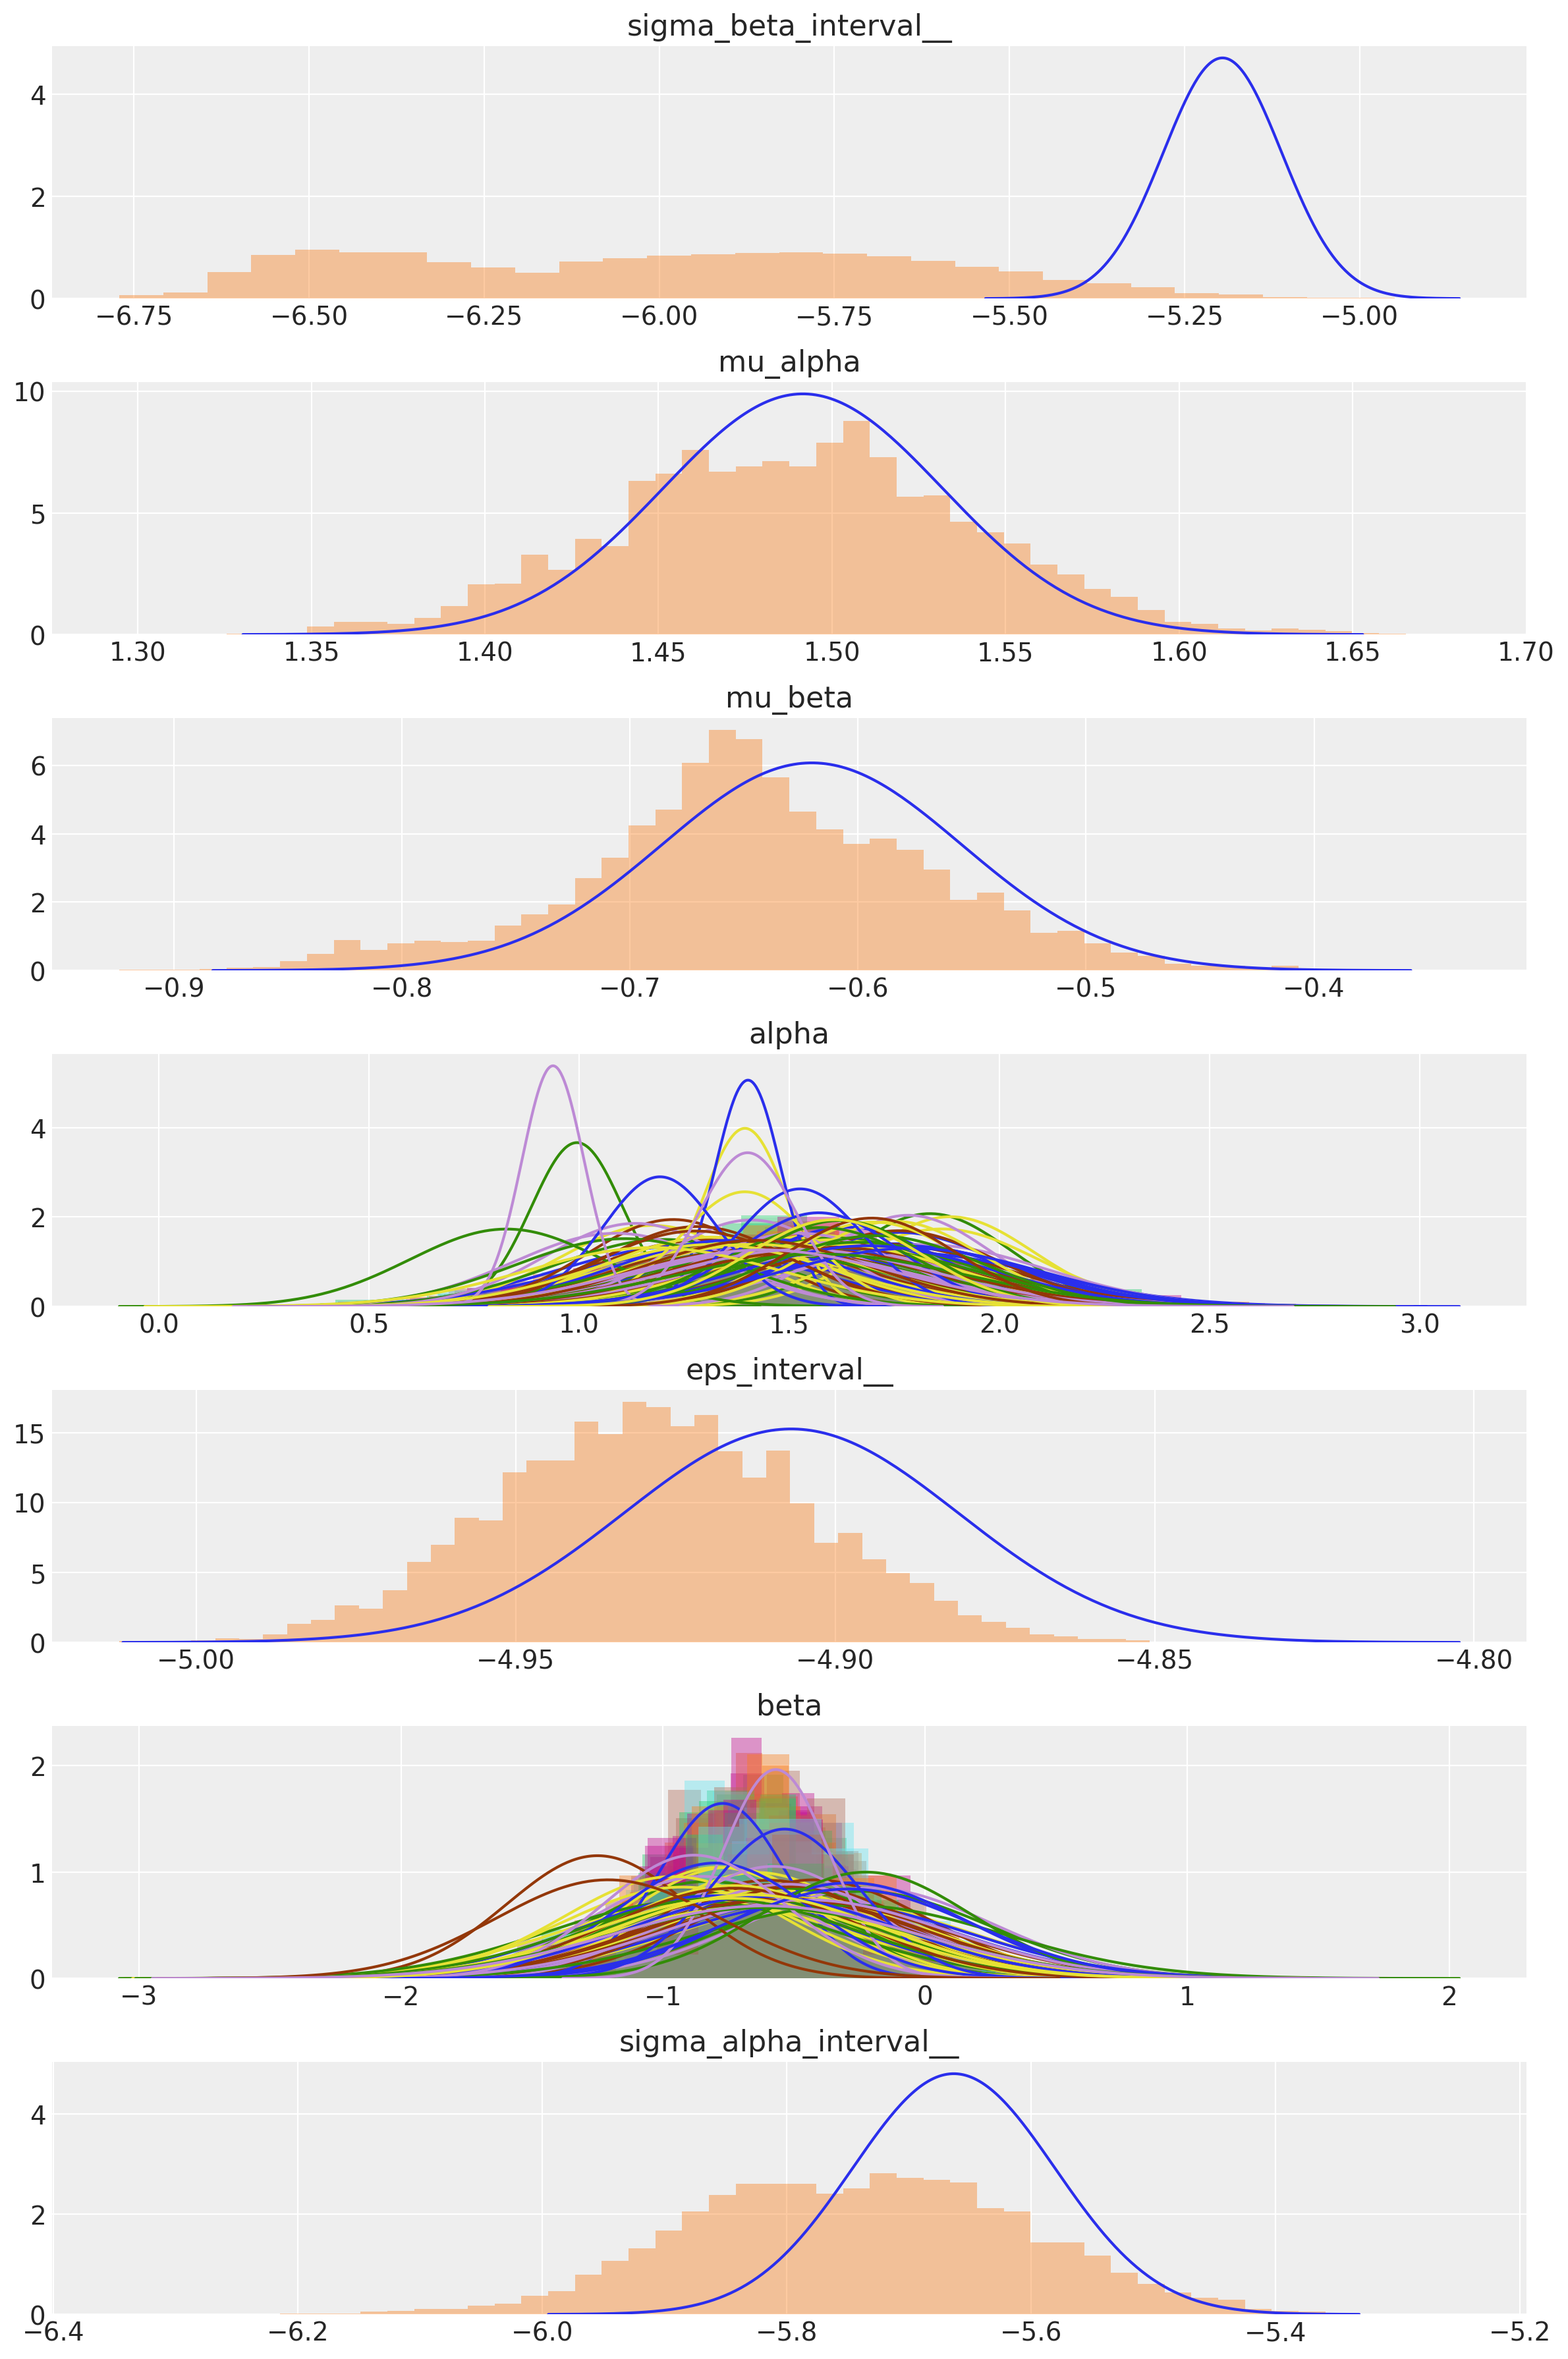

In [13]:
import seaborn as sns

from scipy import stats

varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.10.1
theano  1.0.4
pandas  1.0.4
numpy   1.18.5
arviz   0.8.3
pymc3   3.9.0
last updated: Mon Jun 15 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
